In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import morphology as morpho
from scipy.ndimage import morphology as ndmorph

In [3]:
def random_distribution(percentage, size, space=[1]):
    nb_total = size[0] * size[1]
    nb_el = int(nb_total * percentage / 100)
    arr = np.zeros(nb_total)
    for i in range(len(space)):
        start_index = i * nb_el
        arr[start_index:start_index + nb_el] = space[i]
    
    np.random.shuffle(arr)
    return arr.reshape(size)

def salt_noise(image_ar, percentage=5):
    print(image_ar.shape)
    rand = random_distribution(percentage, size=image_ar.shape)
    return np.ma.masked_array(image_ar, rand.reshape(image_ar.shape)).filled(254)

def pepper_noise(image_ar, percentage=5):
    rand = random_distribution(percentage, size=image_ar.shape)
    return np.ma.masked_array(image_ar, rand.reshape(image_ar.shape)).filled(1)

def salt_pepper_noise(image_ar, percentage=5):
    rand = random_distribution(percentage, image_ar.shape, [1, 2])
    arr = np.ma.masked_array(image_ar, (rand == 1).reshape(image_ar.shape)).filled(1)
    return np.ma.masked_array(arr, (rand == 2).reshape(image_ar.shape)).filled(254)

In [4]:
os.listdir('../standard')

['cameraman.tif',
 'house.tif',
 'jetplane.tif',
 'lake.tif',
 'lena_color_256.tif',
 'lena_color_512.tif',
 'lena_gray_256.tif',
 'lena_gray_512.tif',
 'livingroom.tif',
 'mandril_color.tif',
 'mandril_gray.tif',
 'peppers_color.tif',
 'peppers_gray.tif',
 'pirate.tif',
 'walkbridge.tif',
 'woman_blonde.tif',
 'woman_darkhair.tif']

In [5]:
imgs = []
img = cv2.cvtColor(cv2.imread('../standard/jetplane.tif'), cv2.COLOR_BGR2GRAY)

(512, 512)


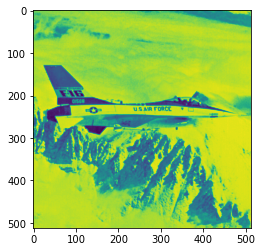

In [6]:
plt.imshow(img)
print(img.shape)

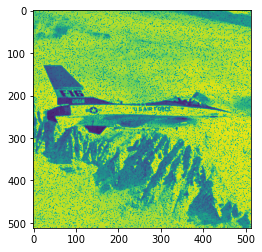

In [7]:
plt.imshow(pepper_noise(img))

In [8]:
imgs = []
for image_path in ['cameraman.tif', 'peppers_gray.tif', 'lena_gray_512.tif', 'mandril_gray.tif', 'house.tif', 'jetplane.tif']:
    imgs.append(cv2.cvtColor(cv2.imread('../standard/' + image_path), cv2.COLOR_BGR2GRAY))
imgs = np.array(imgs)

(6, 512, 512)


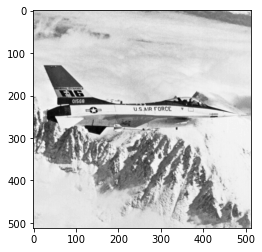

In [9]:
print(imgs.shape)
for i in imgs:
    plt.imshow(i, cmap='gray')

In [10]:
func = np.vectorize(salt_noise)
func(imgs)

()


IndexError: tuple index out of range

In [11]:
import argparse
parser = argparse.ArgumentParser()

In [12]:
parser.add_argument("one")
parser.add_argument("two", choices=['1', '2', '3', '4'])

_StoreAction(option_strings=[], dest='two', nargs=None, const=None, default=None, type=None, choices=['1', '2', '3', '4'], help=None, metavar=None)

In [13]:
parser.parse_args("asasd".split())

usage: ipykernel_launcher.py [-h] one {1,2,3,4}
ipykernel_launcher.py: error: the following arguments are required: two


SystemExit: 2

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


(34, 34)
(28, 28)


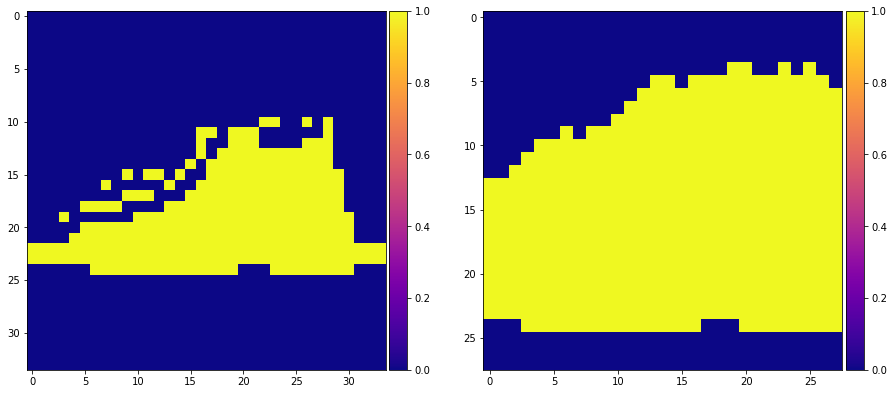

In [14]:
path = "../test/fashion_mnist_smorphnet_mse_bdilation_bdiamond_1"
fig = plt.figure(figsize=(15,15))
with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    ax = fig.add_subplot(121)
    p = ax.imshow(file["inputs"][()].squeeze()[0], cmap='plasma')
    #ax.axis('off')
    print(file["inputs"][()].squeeze()[0].shape)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)

    ax = fig.add_subplot(122)
    p = ax.imshow(file["targets"][()].squeeze()[0], cmap='plasma')
    print(file["targets"][()].squeeze()[0].shape)
    #ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    input = file["inputs"][()].squeeze()[0]

In [4]:
def center_in(arr, shape, dtype="float32"):
    res = np.zeros(shape=shape, dtype=dtype)
    pad_before = (shape[0] - arr.shape[0]) // 2, (shape[1] - arr.shape[1]) // 2
    pad_after = shape[0] - pad_before[0], shape[1] - pad_before[1]
    res[pad_before[0] : pad_after[0], pad_before[1] : pad_after[1]] = arr
    return res

def shape_aa(original, target_shape):
    from skimage import transform

    return transform.resize(
         original, target_shape, preserve_range=True, anti_aliasing=True
    )

def draw_disk(radius, shape=None, dtype="float32"):
    from skimage import morphology
 
    res = morphology.disk(radius).astype(dtype)
    if shape is not None:
        return center_in(res, shape)

    return res

def draw_diamond(radius, shape=None, dtype="float32"):
    from skimage import morphology
 
    res = morphology.diamond(radius).astype(dtype)
    if shape is not None:
        return center_in(res, shape)

    return res

def draw_disk_aa(radius, shape=None, dtype="float32"):
    from skimage import transform
    dim = radius * 2 + 1
    res = draw_disk(dim, dtype=dtype)
    res = shape_aa(res, (dim, dim))

    if shape is not None:
        return center_in(res, shape)
    return res

def draw_diamond_aa(radius, shape=None, dtype="float32"):
    dim = radius * 2 + 1
    res = draw_diamond(dim, dtype=dtype)
    res = shape_aa(res, (dim, dim))

    if shape is not None:
        return center_in(res, shape)
    return res

def draw_cross(size, shape=None, dtype="float32"):
    res = np.zeros((size, size), dtype=dtype)
    res[size // 2, :] = 1.0
    res[:, size // 2] = 1.0
    if shape is not None:
        return center_in(res, shape, dtype=dtype)
    return res
    
def draw_x(size, shape=None, dtype="float32"):
    x, y = np.mgrid[0:size,0:size]
    res = np.zeros((size, size), dtype=dtype)
    res [x == y] = 1.0
    if shape is not None:
        return center_in(res, shape, dtype=dtype)
    return res

def draw_rand(filter_shape, dtype="float32"):
    rng = default_rng()
    return rng.normal(size=filter_shape, loc=1.5, scale=0.05).astype(dtype)

def draw_complex(filter_shape, dtype="float32"):
    return draw_disk_aa(3, filter_shape, dtype=dtype) - draw_diamond_aa(2, filter_shape, dtype=dtype)

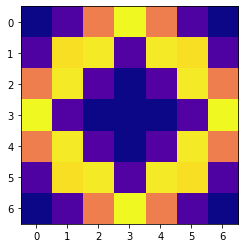

In [4]:
complex = draw_complex((7, 7))
plt.imshow(complex, cmap='plasma')

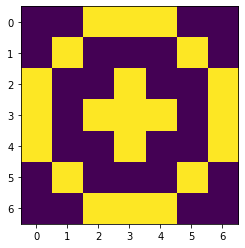

In [31]:
plt.imshow((draw_disk_aa(3, (7, 7)) - draw_disk_aa(2, (7, 7)) > 0.5) + draw_diamond(1, (7, 7)), cmap='plasma')

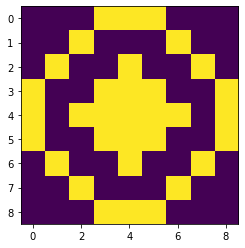

In [10]:
#double_disk9_2
plt.imshow((draw_disk_aa(4, (9, 9)) - draw_disk_aa(3, (9, 9)) > 0.5) + draw_diamond(2, (9, 9)))

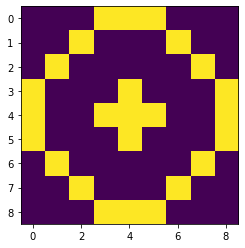

In [12]:
#double_disk9_1
plt.imshow((draw_disk_aa(4, (9, 9)) - draw_disk_aa(3, (9, 9)) > 0.5) + draw_diamond(1, (9, 9)))

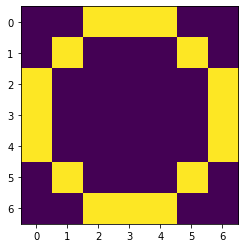

In [21]:
#double_disk7_0
d = (draw_disk_aa(3, (7, 7)) - draw_disk_aa(2, (7, 7)) > 0.5)# + draw_disk(0, (7, 7))
plt.imshow(d)

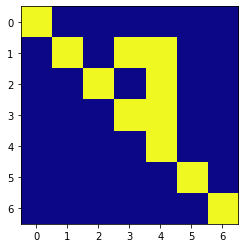

In [39]:
d = np.diag([1] * 7)
d[3, 4:5] = 1
d[1:3, 4] = 1
d[1, 3] = 1

plt.imshow(d, cmap='plasma')

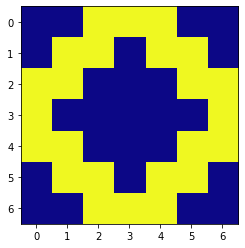

In [15]:
plt.imshow(np.where(complex < 0.5, 0, 1), cmap='plasma')

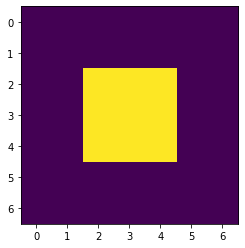

In [21]:
plt.imshow(center_in(np.ones((3, 3), dtype="float32"), (7, 7), dtype="float32"))

In [22]:
radius = 3
L = np.arange(0, radius * 2 + 1)
I, J = np.meshgrid(L, L)
res = np.array(np.abs(I - radius) + np.abs(J - radius) <= radius,
                    dtype="float32")

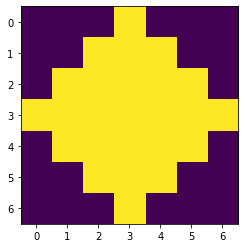

In [23]:
plt.imshow(res)

Text(0.5, 1.0, 'min: -0.28434809379445714, max: 4.1479656154665925')

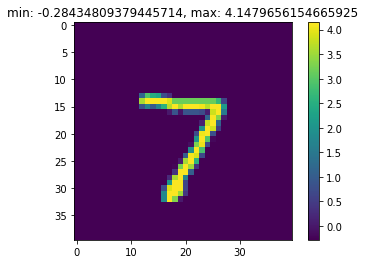

In [67]:
plt.imshow(input)
plt.colorbar()
plt.title(f"min: {np.min(input)}, max: {np.max(input)}")

In [34]:
output = ndmorph.grey_dilation(input, structure=center_in(np.ones((3, 3), dtype="float32"), (7, 7), dtype="float32"))

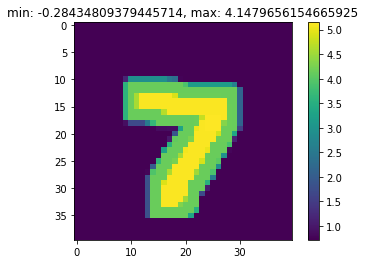

In [52]:
plt.imshow(output)
plt.title(f"min: {np.min(input)}, max: {np.max(input)}")
plt.colorbar()

In [41]:
array = np.zeros((6, 6))

In [44]:
array[2:4, 2:4] = 1

In [45]:
array

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Text(0.5, 1.0, 'min: False, max: True')

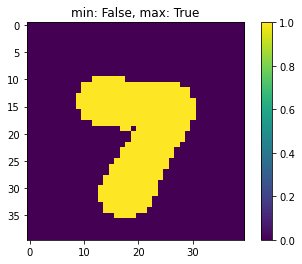

In [70]:
res = ndmorph.binary_dilation(input > 0, structure=morpho.disk(3))
plt.imshow(res)
plt.colorbar()
plt.title(f"min: {np.min(res)}, max: {np.max(res)}")

In [104]:
complex = draw_diamond_aa(3)

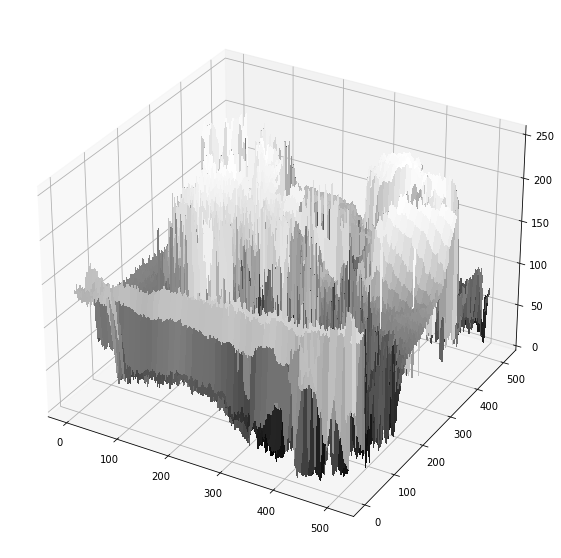

In [142]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

# Make data.
X = np.arange(image.shape[1])
Y = np.arange(image.shape[0])
X, Y = np.meshgrid(X, Y)
Z = image.swapaxes(0, 1)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='Greys_r',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 255.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

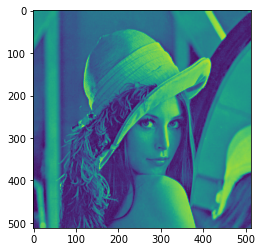

In [126]:
from PIL import Image
# Open the image form working directory
image = np.array(Image.open('leba.jpg'))
# summarize some details about the image
# show the image
plt.imshow(image)